<a href="https://colab.research.google.com/github/WIVIV/stock_screener/blob/master/Stock_Screener_V1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install simfin

     |████████████████████████████████| 61kB 4.8MB/s 


In [5]:
import tensorflow as tf

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow is already loaded. Please restart the runtime to change versions.
Found GPU at: /device:GPU:0


## Imports

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from datetime import datetime, timedelta
import os

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [7]:
# Version of the SimFin Python API.
sf.__version__

'0.4.0'

In [0]:
# Boolean whether this is being run under pytest. We will
# use this to make certain parts of the tutorial run faster.
running_pytest = ('PYTEST_CURRENT_TEST' in os.environ)

## Config

In [0]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

In [0]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [0]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

## Data Hub

In these examples, we will use stock-data for USA. It is very easy to load and process the data using the `sf.StockHub` class. We instruct it to refresh the financial data every 30 days, and the share-price data must be refreshed daily.

In [0]:
hub = sf.StockHub(market='us',
                  refresh_days=30,
                  refresh_days_shareprices=1)

The data-hub not only makes the syntax very simple, but it also takes care of downloading the required datasets from the SimFin server and loading them into Pandas DataFrames. Furthermore, the data-hub's slow processing functions use a disk-cache to save the results for the next time the functions are called, and the cache automatically gets refreshed when new datasets are downloaded from the SimFin server. Lastly, the data-hub's functions are also RAM-cached, so the second time you call them, they return the results nearly instantly. Altogether, the data-hub makes it much easier and faster to work with the data.

## Financial Signals

First we calculate financial signals for the stocks, such as the Current Ratio, Debt Ratio, Net Profit Margin, Return on Assets, etc. These are calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

Note that we set `variant='latest'` because we are only interested in the most recent signals, and we are not interested in the signals from several years ago.

In [13]:
%%time
df_fin_signals = hub.fin_signals(variant='latest')

Dataset "us-income-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-shareprices-latest" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Cache-file 'fin_signals-899db0b4.pickle' not on disk.
- Running function fin_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 16.1 s, sys: 443 ms, total: 16.5 s
Wall time: 17.9 s


In [14]:
df_fin_signals.dropna().head()

,,Asset Turnover,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity
Ticker,Date,,,,,,,
A,2020-03-12,0.573350,3.389954,0.210631,0.545619,0.228594,0.131065,0.251878
AA,2020-03-12,0.768212,1.416238,0.113063,0.247855,0.016937,0.013011,0.033392
AAL,2020-03-12,0.843819,0.477288,0.403978,0.266945,0.031701,0.026750,-1.810256
AAOI,2020-03-12,0.590451,2.509429,0.179755,0.328166,-0.008023,-0.004737,-0.006439
AAP,2020-03-12,1.129476,1.565242,0.123951,0.440414,0.044240,0.049968,0.124106


We then pass the argument `func=sf.avg_ttm_2y` to `hub.fin_signals`, so as to calculate 2-year averages of the financial signals. We then get another DataFrame with the 2-year average Current Ratio, Net Profit Margin, Return on Assets, etc.

In [15]:
%%time
df_fin_signals_2y = hub.fin_signals(variant='latest',
                                    func=sf.avg_ttm_2y)

Cache-file 'fin_signals-4a256f6a.pickle' not on disk.
- Running function fin_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 21.5 s, sys: 45.7 ms, total: 21.5 s
Wall time: 21.5 s


In [16]:
df_fin_signals_2y.dropna().head()

,,Asset Turnover,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity
Ticker,Date,,,,,,,
A,2020-03-12,0.579866,3.310334,0.224649,0.544473,0.135528,0.077981,0.148730
AAL,2020-03-12,0.833493,0.536404,0.439415,0.284573,0.038584,0.032088,-0.651628
AAOI,2020-03-12,0.888319,2.878979,0.144581,0.381540,0.092699,0.112349,0.159393
AAP,2020-03-12,1.128403,1.562325,0.141038,0.438105,0.047484,0.053577,0.143582
AAPL,2020-03-12,0.682693,1.271283,0.303942,0.383206,0.219209,0.149337,0.402771


## Growth Signals

Now we calculate growth signals for the stocks, such as Earnings Growth, FCF Growth, Sales Growth, etc. These are also calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

In [17]:
%%time
df_growth_signals = hub.growth_signals(variant='latest')

Dataset "us-income-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Cache-file 'growth_signals-899db0b4.pickle' not on disk.
- Running function growth_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 18.9 s, sys: 238 ms, total: 19.1 s
Wall time: 20.6 s


In [18]:
df_growth_signals.dropna().head()

,,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,FCF Growth QOQ,FCF Growth YOY,Sales Growth,Sales Growth QOQ,Sales Growth YOY
Ticker,Date,,,,,,,,,
A,2020-03-12,4.816327,1.584615,-2.575000,0.186224,-0.483680,0.122581,0.080373,-0.007728,0.060281
AA,2020-03-12,0.046083,-2.048780,-1.219388,-0.940171,0.878641,0.264706,0.150275,-0.013569,0.053560
AAL,2020-03-12,-0.264200,-0.064516,0.236434,-5.242857,-1.539419,-1.304094,0.055299,-0.053724,0.031887
AAN,2020-03-12,-0.329279,0.412237,-0.652270,1.519114,-1.371859,-0.166560,0.131576,0.042088,0.122715
AAOI,2020-03-12,-1.029019,1.295820,-2.498950,-4.390864,1.361792,-6.006395,-0.300432,0.028943,-0.273458


We then pass the argument `func=sf.avg_ttm_2y` to `hub.growth_signals` so as to calculate 2-year averages of the growth signals. We then get another DataFrame with the 2-year average Earnings Growth, FCF Growth, Sales Growth, etc.

In [19]:
%%time
df_growth_signals_2y = hub.growth_signals(variant='latest',
                                          func=sf.avg_ttm_2y)

Cache-file 'growth_signals-4a256f6a.pickle' not on disk.
- Running function growth_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 25.3 s, sys: 61.3 ms, total: 25.3 s
Wall time: 25.4 s


In [20]:
df_growth_signals_2y.dropna().head()

,,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,FCF Growth QOQ,FCF Growth YOY,Sales Growth,Sales Growth QOQ,Sales Growth YOY
Ticker,Date,,,,,,,,,
A,2020-03-12,2.100698,-0.611647,-2.739881,0.182586,-0.404883,0.483909,0.084398,0.005387,0.097619
AAL,2020-03-12,-0.273543,-0.325527,0.064584,-3.274267,-0.382780,-0.595406,0.052873,-0.039640,0.057423
AAN,2020-03-12,0.385510,3.209532,3.278160,0.392771,-1.515437,2.011237,0.093221,0.048309,0.117759
AAOI,2020-03-12,0.169313,0.295420,-1.548561,-1.503961,-0.071668,-3.331621,0.083021,-0.036294,-0.166440
AAON,2020-03-12,-0.098907,-0.019213,0.088040,-0.241691,-9.740884,3.554053,0.063108,-0.044467,0.107404


## Valuation Signals

Now we calculate valuation signals for the stocks, such as P/E, P/Sales, etc. These are calculated from the share-prices and data from the financial reports. Because the data-hub has already loaded the required datasets in the function-calls above, the data is merely reused here, and the data-hub can proceed directly to computing the signals.

In [21]:
%%time
df_val_signals = hub.val_signals(variant='latest')

Cache-file 'val_signals-9541e2e6.pickle' not on disk.
- Running function val_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 3.82 s, sys: 21.1 ms, total: 3.84 s
Wall time: 3.83 s


In [22]:
df_val_signals.dropna().head()

,,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
Ticker,Date,,,,,,,,,,
A,2020-03-12,0.009468,0.055352,0.045155,2.059564e+10,4.089683,18.066355,22.145855,-100.959044,-22.688675,4.129867
AAL,2020-03-12,0.029698,0.225446,0.189682,6.263127e+09,-37.059923,4.435642,5.271992,-0.120186,-0.116095,0.140615
AAN,2020-03-12,0.003186,0.100119,0.146366,1.959773e+09,1.113059,9.988139,6.832190,4.158898,-7.516282,0.511834
AAP,2020-03-12,0.002206,0.052472,0.076657,8.077597e+09,2.274859,19.057814,13.045194,13.630338,-4.156628,0.843124
AAPL,2020-03-12,0.011452,0.048821,0.050910,1.217314e+12,10.325669,20.482808,19.642647,-10.585429,-7.938231,4.653127


We then pass the argument `func=sf.avg_ttm_2y` to `hub.val_signals` so as to calculate the valuation signals using 2-year averages of the financial data. We then get another DataFrame with e.g. P/E and P/Sales ratios calculated from the 2-year average Earnings and Sales.

In [23]:
%%time
df_val_signals_2y = hub.val_signals(variant='latest',
                                    func=sf.avg_ttm_2y)

Cache-file 'val_signals-2eee516b.pickle' not on disk.
- Running function val_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 19.2 s, sys: 38.1 ms, total: 19.3 s
Wall time: 19.3 s


In [24]:
df_val_signals_2y.dropna().head()

,,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
Ticker,Date,,,,,,,,,,
A,2020-03-12,0.009007,0.032434,0.041611,2.059564e+10,4.307811,30.831804,24.032258,1961.490000,-31.076039,4.289419
AAL,2020-03-12,0.030656,0.265921,0.072488,6.263127e+09,-13.199425,3.760509,13.795434,-0.129764,-0.124696,0.144398
AAN,2020-03-12,0.003624,0.124695,0.102234,1.959773e+09,1.123494,8.019596,9.781477,3.934662,-8.550618,0.543428
AAP,2020-03-12,0.002208,0.055670,0.064459,8.077597e+09,2.319146,17.963150,15.513748,16.962509,-4.116540,0.852322
AAPL,2020-03-12,0.011057,0.045163,0.047406,1.217314e+12,9.433214,22.141834,21.094368,-10.238820,-7.537552,4.861593


## Combine Signals

We now combine all the basic signals into a single DataFrame:

In [25]:
# Combine the DataFrames.
dfs = [df_fin_signals, df_growth_signals, df_val_signals]
df_signals = pd.concat(dfs, axis=1)

# Show the result.
df_signals.head()

,,Asset Turnover,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,FCF Growth QOQ,FCF Growth YOY,Sales Growth,Sales Growth QOQ,Sales Growth YOY,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
Ticker,Date,,,,,,,,,,,,,,,,,,,,,,,,,,
A,2020-03-12,0.573350,3.389954,0.210631,0.545619,0.228594,0.131065,0.251878,4.816327,1.584615,-2.575000,0.186224,-0.483680,0.122581,0.080373,-0.007728,0.060281,0.009468,0.055352,0.045155,2.059564e+10,4.089683,18.066355,22.145855,-100.959044,-22.688675,4.129867
AA,2020-03-12,0.768212,1.416238,0.113063,0.247855,0.016937,0.013011,0.033392,0.046083,-2.048780,-1.219388,-0.940171,0.878641,0.264706,0.150275,-0.013569,0.053560,NaN,0.159928,0.034522,1.419390e+09,0.191965,6.252819,28.967143,-0.321857,-0.237098,0.105901
AAC,2019-11-04,NaN,2.117862,0.500277,0.402427,-0.077948,NaN,NaN,NaN,-0.970076,-2.029010,NaN,-0.254475,1.312272,NaN,0.009495,0.117693,NaN,-2.166485,-3.940417,1.034256e+07,0.066510,-0.461577,-0.253780,-0.075938,-0.062823,0.035979
AAL,2020-03-12,0.843819,0.477288,0.403978,0.266945,0.031701,0.026750,-1.810256,-0.264200,-0.064516,0.236434,-5.242857,-1.539419,-1.304094,0.055299,-0.053724,0.031887,0.029698,0.225446,0.189682,6.263127e+09,-37.059923,4.435642,5.271992,-0.120186,-0.116095,0.140615
AAME,2020-03-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Then we combine all the signals for multi-year averages into another DataFrame:

In [26]:
# Combine the DataFrames.
dfs = [df_fin_signals_2y, df_growth_signals_2y, df_val_signals_2y]
df_signals_2y = pd.concat(dfs, axis=1)

# Show the result.
df_signals_2y.head()

,,Asset Turnover,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,FCF Growth QOQ,FCF Growth YOY,Sales Growth,Sales Growth QOQ,Sales Growth YOY,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
Ticker,Date,,,,,,,,,,,,,,,,,,,,,,,,,,
A,2020-03-12,0.579866,3.310334,0.224649,0.544473,0.135528,0.077981,0.148730,2.100698,-0.611647,-2.739881,0.182586,-0.404883,0.483909,0.084398,0.005387,0.097619,0.009007,0.032434,0.041611,2.059564e+10,4.307811,30.831804,24.032258,1961.490000,-31.076039,4.289419
AA,2020-03-12,NaN,1.359718,0.096768,0.234638,0.017780,NaN,NaN,NaN,-2.391647,-0.325694,NaN,0.472421,1.277514,NaN,0.028640,0.152322,NaN,0.156405,0.305765,1.419390e+09,0.200027,6.393649,3.270484,-0.262340,-0.203603,0.113302
AAC,2019-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.034256e+07,NaN,NaN,NaN,NaN,NaN,NaN
AAL,2020-03-12,0.833493,0.536404,0.439415,0.284573,0.038584,0.032088,-0.651628,-0.273543,-0.325527,0.064584,-3.274267,-0.382780,-0.595406,0.052873,-0.039640,0.057423,0.030656,0.265921,0.072488,6.263127e+09,-13.199425,3.760509,13.795434,-0.129764,-0.124696,0.144398
AAME,2020-03-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Screener for Net-Net Stocks

This is an old investment strategy used by Ben Graham who was the teacher of Warren Buffett, who also used the strategy when he started investing. The idea is to buy stocks that are cheaper than a conservative estimate of their liquidation value. In normal market conditions, few companies have stocks that trade at such low prices, and there may be very good reasons why the stocks are so cheap. But during market panics, it is sometimes possible to buy decent stocks at such low prices.

The Net-Net formula is:

$$
    NetNet = Cash\ \&\ Equiv + 0.75 \cdot Receivables \\
    + 0.5 \cdot Inventories - Total\ Liabilities
$$

This means P/NetNet ratios between 0 and 1 indicate the stocks are trading at a discount to their estimated liquidation values. The lower the P/NetNet ratio, the cheaper the stock is.

We create the stock-screener for Net-Net stocks, by making a boolean mask for the rows in the DataFrame with signals that meet the criteria: P/NetNet > 0 and P/NetNet < 1

In [0]:
mask = (df_signals[P_NETNET] > 0) & (df_signals[P_NETNET] < 1)

Rows that satisfy the screener-condition have a value of `True` and rows that do not meet the condition have a value of `False`.

In [28]:
mask.head()

Ticker  Date      
A       2020-03-12    False
AA      2020-03-12    False
AAC     2019-11-04    False
AAL     2020-03-12    False
AAME    2020-03-12    False
Name: P/NetNet, dtype: bool

We can then use the boolean mask to select matching rows in the signal DataFrame, and show the P/NetNet signal:

In [29]:
df_signals.loc[mask, P_NETNET]

Ticker  Date      
ALPN    2020-03-12    0.982162
ALRN    2020-03-12    0.524097
AMDA    2020-03-12    0.062867
AVGR    2020-03-12    0.083448
BLCM    2020-03-12    0.584791
CGA     2020-03-12    0.034622
CLBS    2020-03-12    0.543417
CLRB    2020-03-12    0.434121
CRVS    2020-03-12    0.636823
CYCC    2020-03-12    0.448079
CYIG    2020-03-11    0.086013
EFOI    2020-03-12    0.847310
EVLO    2020-03-12    0.755857
FNJN    2020-03-12    0.860965
FPRX    2020-03-12    0.388850
GLYC    2020-03-12    0.541346
GTXI    2020-03-12    0.655415
HTGM    2020-03-12    0.758397
KKR     2020-03-12    0.534378
KOPN    2020-03-12    0.607149
MN      2020-03-12    0.572235
NHTC    2020-03-12    0.501239
NLNK    2020-03-12    0.407558
NSPR    2020-03-12    0.036377
OMED    2020-02-03    0.800006
ONVO    2020-03-12    0.789187
RAIL    2020-03-12    0.887752
RKDA    2020-03-12    0.443056
SIGN    2020-03-12    0.323190
SINO    2020-03-12    0.770997
SOHU    2020-03-12    0.451337
SPRT    2020-03-12  

Note that some of the dates are not recent, so we can remove all rows with dates that are older than e.g. 30 days, by creating another boolean mask.

In [30]:
# Oldest date that is allowed for a row.
date_limit = datetime.now() - timedelta(days=30)

# Load the latest share-prices from the data-hub.
df_prices_latest = hub.load_shareprices(variant='latest')

# Boolean mask for the tickers that satisfy this condition.
mask_date_limit = (df_prices_latest.reset_index(DATE)[DATE] > date_limit)

# Show the result.
mask_date_limit.head()

Ticker
A        True
AA       True
AAC     False
AAL      True
AAME     True
Name: Date, dtype: bool

We can then combine the screener-mask and the date-mask:

In [0]:
mask &= mask_date_limit

And then we can show the recent stock-prices that are trading at Net-Net discounts:

In [32]:
df_signals.loc[mask, P_NETNET]

Ticker  Date      
ALPN    2020-03-12    0.982162
ALRN    2020-03-12    0.524097
AMDA    2020-03-12    0.062867
AVGR    2020-03-12    0.083448
BLCM    2020-03-12    0.584791
CGA     2020-03-12    0.034622
CLBS    2020-03-12    0.543417
CLRB    2020-03-12    0.434121
CRVS    2020-03-12    0.636823
CYCC    2020-03-12    0.448079
CYIG    2020-03-11    0.086013
EFOI    2020-03-12    0.847310
EVLO    2020-03-12    0.755857
FNJN    2020-03-12    0.860965
FPRX    2020-03-12    0.388850
GLYC    2020-03-12    0.541346
GTXI    2020-03-12    0.655415
HTGM    2020-03-12    0.758397
KKR     2020-03-12    0.534378
KOPN    2020-03-12    0.607149
MN      2020-03-12    0.572235
NHTC    2020-03-12    0.501239
NLNK    2020-03-12    0.407558
NSPR    2020-03-12    0.036377
ONVO    2020-03-12    0.789187
RAIL    2020-03-12    0.887752
RKDA    2020-03-12    0.443056
SIGN    2020-03-12    0.323190
SINO    2020-03-12    0.770997
SOHU    2020-03-12    0.451337
SPRT    2020-03-12    0.450960
SRRA    2020-03-12  

## Screener for Many Criteria

It is very easy to combine many criteria in the stock-screener. Let use start with the condition that the Market Capitalization must be more then USD 1 billion:

In [0]:
mask = (df_signals[MARKET_CAP] > 1e9)

Then let us add criteria for the Current Ratio and Debt Ratio calculated from the latest financial reports, as well as the quarterly sales-growth year-over-year.

We combine all these criteria simply by generating the corresponding boolean masks, and doing the logical-and with the previous mask, thereby accumulating multiple criteria.

In [0]:
mask &= (df_signals[CURRENT_RATIO] > 2)
mask &= (df_signals[DEBT_RATIO] < 0.5)
mask &= (df_signals[SALES_GROWTH_YOY] > 0.1)

We can also create screener-criteria using the 2-year average signals, e.g. the P/E and P/FCF ratios which use 2-year average Earnings and FCF. We can combine screener-criteria from `df_signals` and `df_signals_2y` because their indices are compatible.

In [0]:
mask &= (df_signals_2y[PE] < 20)
mask &= (df_signals_2y[PFCF] < 20)
mask &= (df_signals_2y[ROA] > 0.03)
mask &= (df_signals_2y[ROE] > 0.15)
mask &= (df_signals_2y[NET_PROFIT_MARGIN] > 0.0)
mask &= (df_signals_2y[SALES_GROWTH] > 0.1)

Finally we can ensure that we only get the stocks with recent share-prices:

In [0]:
mask &= mask_date_limit

These are the stocks and signals matching all these criteria:

In [37]:
df_signals[mask]

,,Asset Turnover,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,FCF Growth QOQ,FCF Growth YOY,Sales Growth,Sales Growth QOQ,Sales Growth YOY,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
Ticker,Date,,,,,,,,,,,,,,,,,,,,,,,,,,
AIT,2020-03-12,2.439706,2.747120,0.422532,0.290945,0.047992,0.117086,0.211237,0.118838,-0.208856,0.250953,0.454933,4.749569,6.215780,0.266285,-0.028313,0.259074,0.028004,0.099000,0.104324,1.662709e+09,1.868391,10.100960,9.585547,-5.223881,-2.331075,0.484763
CORT,2020-03-12,1.139251,6.657296,0.297553,0.979244,0.300143,0.341938,0.394883,-0.415979,0.240097,-0.776182,0.906388,-0.518534,-0.138730,0.578175,0.037024,0.254336,NaN,0.056798,0.086893,1.327690e+09,4.812529,17.606289,11.508406,6.605161,7.118792,5.284402
EXEL,2020-03-12,1.302966,8.504779,0.347970,0.969141,0.808209,1.053069,2.421630,3.474379,1.843631,8.355634,1.646240,-0.320384,1.839984,0.887004,0.020311,0.915309,NaN,0.144661,0.080233,4.770246e+09,3.705180,6.912698,12.463704,6.258662,6.958801,5.586906
KLAC,2020-03-12,0.796050,3.025564,0.399333,0.643106,0.330051,0.262737,1.159157,1.164564,-0.067797,-3.747936,0.315473,-0.193503,2.130774,0.133390,0.024366,0.147646,0.022838,0.072669,0.076817,1.955021e+10,12.237066,13.761044,13.017962,40.912936,-61.669460,4.541853
NUE,2020-03-12,1.582405,3.077456,0.239453,0.171355,0.094177,0.149026,0.259859,0.790239,-0.044154,0.684799,1.297702,-0.822267,-0.000694,0.237744,-0.066198,0.236347,0.048236,0.234608,0.143403,1.006261e+10,0.986340,4.262431,6.973346,10.965687,-4.650416,0.401424
PRGO,2020-03-12,0.899451,3.183860,0.360024,0.364800,0.120889,0.108734,0.227802,0.025325,-0.059288,0.054924,0.245239,-0.527664,1.089701,0.150945,-0.034962,0.212523,0.008839,0.116393,0.125467,3.846436e+09,1.557325,8.591548,7.970236,-5.726420,-2.881981,1.038623
STLD,2020-03-12,1.724373,3.956933,0.308523,0.196485,0.106445,0.183551,0.380599,0.548315,-0.322237,-0.113965,1.047188,0.224077,1.763368,0.239343,-0.099163,0.242850,0.038324,0.285507,0.266835,4.407517e+09,1.133845,3.502535,3.747637,20.374703,-4.199307,0.372828
XEC,2020-03-12,0.463848,2.009489,0.095042,0.770853,0.338540,0.157031,0.308320,0.601870,1.131267,0.809898,-5.588082,-1.024098,-1.876748,0.219350,0.055171,0.132829,0.038866,0.557103,0.400201,1.421373e+09,0.426866,1.795001,2.498744,-1.086545,-0.746576,0.607680


We can also show a sub-set of all the signals and sort e.g. by the P/FCF ratios:

In [38]:
columns = [PFCF, PE, ROA, ROE, CURRENT_RATIO, DEBT_RATIO]
df_signals.loc[mask, columns].sort_values(by=PFCF, ascending=True)

,,P/FCF,P/E,Return on Assets,Return on Equity,Current Ratio,Debt Ratio
Ticker,Date,,,,,,
XEC,2020-03-12,2.498744,1.795001,0.157031,0.308320,2.009489,0.095042
STLD,2020-03-12,3.747637,3.502535,0.183551,0.380599,3.956933,0.308523
NUE,2020-03-12,6.973346,4.262431,0.149026,0.259859,3.077456,0.239453
PRGO,2020-03-12,7.970236,8.591548,0.108734,0.227802,3.183860,0.360024
AIT,2020-03-12,9.585547,10.100960,0.117086,0.211237,2.747120,0.422532
CORT,2020-03-12,11.508406,17.606289,0.341938,0.394883,6.657296,0.297553
EXEL,2020-03-12,12.463704,6.912698,1.053069,2.421630,8.504779,0.347970
KLAC,2020-03-12,13.017962,13.761044,0.262737,1.159157,3.025564,0.399333


## Handling NaN Signal-Values

The signals are calculated from various financial data using mathematical formulas. If any data-item in the formula is NaN (Not-a-Number) then the result of the entire formula is also NaN, and then the screener-condition automatically evaluates to False, so the company is excluded from the results of the stock-screener.

For example, the Debt Ratio (`DEBT_RATIO`) is calculated from Short Term Debt (`ST_DEBT`), Long Term Debt (`LT_DEBT`) and Total Assets (`TOTAL_ASSETS`). If just one of these numbers is NaN, then the resulting Debt Ratio is also NaN and the screener-condition for this signal will always evaluate to False, so the company is excluded from the screener's results.

You might think that a solution would simply be to use `fillna(0)` on all the data-items before calculating the signals. This may work for some formulas and for some uses of the signals, but it is not a generally valid solution, as it may severely distort the signals.

Consider for example the ticker AMZN, where all data for Short Term Debt is missing in all the reports, while the Long Term Debt is only missing in some reports. If you look at the data, it seems most likely that this is a data-error, and the Long Term Debt should actually be several billions of dollars. If we were to replace these missing values with zeros, then we would get very misleading Debt Ratios.

In this example, AMZN had actually not reported these numbers in some of their quarterly reports. That is why the values are missing in the data.

In [39]:
# Load the TTM Balance Sheets from the data-hub.
df_balance_ttm = hub.load_balance(variant='ttm')

# Show the relevant data.
columns = [ST_DEBT, LT_DEBT, TOTAL_ASSETS]
df_balance_ttm.loc['AMZN', columns]['2010':'2013']

,Short Term Debt,Long Term Debt,Total Assets
Report Date,,,
2010-03-31,NaN,1.310000e+08,12042000000
2010-06-30,NaN,1.320000e+08,12397000000
2010-09-30,NaN,1.640000e+08,14162000000
2010-12-31,NaN,NaN,18797000000
2011-03-31,NaN,NaN,16882000000
2011-06-30,NaN,NaN,17941000000
2011-09-30,NaN,NaN,19054000000
2011-12-31,NaN,2.550000e+08,25278000000
2012-03-31,NaN,NaN,20339000000


A simple solution is to ignore signals that are NaN. For example, we could have the following criteria:

In [0]:
# Start the screener with a market-cap condition.
mask = (df_signals[MARKET_CAP] > 1e9)

# Ensure share-prices are recent.
mask &= mask_date_limit

# Screener criteria where NaN signals are ignored.
mask &= ((df_signals[CURRENT_RATIO] > 2) | (df_signals[CURRENT_RATIO].isnull()))
mask &= ((df_signals[DEBT_RATIO] < 0.5) | (df_signals[DEBT_RATIO].isnull()))
mask &= ((df_signals[PE] < 20) | (df_signals[PE].isnull()))
mask &= ((df_signals[PFCF] < 20) | (df_signals[PFCF].isnull()))
mask &= ((df_signals[ROA] > 0.03) | (df_signals[ROA].isnull()))
mask &= ((df_signals[ROE] > 0.15) | (df_signals[ROE].isnull()))
mask &= ((df_signals[NET_PROFIT_MARGIN] > 0.0) | (df_signals[NET_PROFIT_MARGIN].isnull()))
mask &= ((df_signals[SALES_GROWTH] > 0.1) | (df_signals[SALES_GROWTH].isnull()))

The following shows the stocks whose signals match these criteria. You can see that some of the signals are NaN, but the stocks are still included in the results, because the screener just ignores NaN values:

In [41]:
columns = [PFCF, PE, ROA, ROE, CURRENT_RATIO, DEBT_RATIO]
df_signals.loc[mask, columns].sort_values(by=PE, ascending=True)

,,P/FCF,P/E,Return on Assets,Return on Equity,Current Ratio,Debt Ratio
Ticker,Date,,,,,,
CROX,2020-03-12,11.942881,-17.951418,NaN,NaN,2.061336,NaN
XEC,2020-03-12,2.498744,1.795001,0.157031,0.308320,2.009489,0.095042
HFC,2020-03-12,4.878577,2.343259,0.145555,0.270254,2.503984,NaN
HAL,2020-03-12,4.173714,3.399964,0.066016,0.198347,2.322157,0.402471
STLD,2020-03-12,3.747637,3.502535,0.183551,0.380599,3.956933,0.308523
MU,2020-03-12,6.047258,3.542230,0.316506,0.491606,2.248336,0.131404
CPRI,2020-03-12,2.789597,3.891283,0.134628,0.272893,2.479098,0.420360
NKTR,2020-03-12,4.106544,4.259007,1.338885,7.757355,17.532341,0.424793
NUE,2020-03-12,6.973346,4.262431,0.149026,0.259859,3.077456,0.239453


## Back-Testing

We will now test if the stock-screener would have been able to find profitable investments in the past. You can use this method to test which screener-criteria are important and which ones are not, so as to gradually refine your stock-screener.

First we need to calculate the signals for all the historical daily data-points. We will screen for P/E ratios, Sales Growth, Return on Assets, etc., and these signals are highly susceptible to short-term variations, so we will use their 3-year averages instead.

Then we calculate the 1-3 year average annualized log-returns for all the stocks, which is the investment horizon we will consider when testing if the screener's criteria could discover profitable investments in the past. Note that we are calculating the average log-returns for all 1-3 year investment periods, because the log-returns are easier to calculate using Pandas and numpy.

Calculating the signals and returns takes a few minutes to run.

In [42]:
%%time
# Calculate the signals for all daily data-points.
# We pass the arg func=sf.avg_ttm_3y to get the 3-year averages.
df_fin_signals = hub.fin_signals(variant='daily', func=sf.avg_ttm_3y)
df_growth_signals = hub.growth_signals(variant='daily', func=sf.avg_ttm_3y)
df_val_signals = hub.val_signals(variant='daily', func=sf.avg_ttm_3y)

# Combine all the signals into a single DataFrame.
dfs = [df_fin_signals, df_growth_signals, df_val_signals]
df_signals = pd.concat(dfs, axis=1)

# Remove outliers in the signals by clipping / limiting them.
df_signals = sf.winsorize(df=df_signals, clip=True)

# Name of the data-column for the stock-returns.
TOTAL_RETURN_1_3Y = 'Total Return 1-3 Years'

# Calculate the mean log-returns for all 1-3 year periods.
df_returns_1_3y = \
    hub.mean_log_returns(name=TOTAL_RETURN_1_3Y,
                         future=True, annualized=True,
                         min_years=1, max_years=3)

# Combine the signals and mean log-returns into a single DataFrame.
dfs = [df_signals, df_returns_1_3y]
df_sig_rets = pd.concat(dfs, axis=1)

Dataset "us-shareprices-daily" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Cache-file 'fin_signals-92e21ef8.pickle' not on disk.
- Running function fin_signals() ... Done!
- Saving cache-file to disk ... Done!
Cache-file 'growth_signals-92e21ef8.pickle' not on disk.
- Running function growth_signals() ... Done!
- Saving cache-file to disk ... Done!
Cache-file 'val_signals-c16ad832.pickle' not on disk.
- Running function val_signals() ... Done!
- Saving cache-file to disk ... Done!
Cache-file 'mean_log_change-90769289.pickle' not on disk.
- Running function mean_log_change() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 5min 14s, sys: 12.4 s, total: 5min 26s
Wall time: 5min 29s


We can now create a stock-screener similar to how we did it above. We will use nearly the same criteria as above with only minor changes. The result is a Pandas Series with boolean values for each stock and each trading-day, telling us whether or not the screener's criteria were met for that stock on that particular day. We can then use this boolean mask to select only the rows where the screener's criteria were met.

In [0]:
# Start the screener with a market-cap condition.
mask = (df_sig_rets[MARKET_CAP] > 1e9)

# Screener criteria where NaN signals are ignored.
mask &= ((df_sig_rets[CURRENT_RATIO] > 2) | (df_sig_rets[CURRENT_RATIO].isnull()))
mask &= ((df_sig_rets[DEBT_RATIO] < 0.5) | (df_sig_rets[DEBT_RATIO].isnull()))
mask &= (((df_sig_rets[PE] > 0) & (df_sig_rets[PE] < 20)) | (df_sig_rets[PE].isnull()))
mask &= (((df_sig_rets[PFCF] > 0) & (df_sig_rets[PFCF] < 20)) | (df_sig_rets[PFCF].isnull()))
mask &= ((df_sig_rets[ROA] > 0.03) | (df_sig_rets[ROA].isnull()))
mask &= ((df_sig_rets[ROE] > 0.15) | (df_sig_rets[ROE].isnull()))
mask &= ((df_sig_rets[NET_PROFIT_MARGIN] > 0.0) | (df_sig_rets[NET_PROFIT_MARGIN].isnull()))
mask &= ((df_sig_rets[SALES_GROWTH] > 0.0) | (df_sig_rets[SALES_GROWTH].isnull()))
    
# Select the rows that satisfy the screener criteria.
df_match = df_sig_rets.loc[mask]

The table below shows some basic statistics for the historical stock-returns when the screener's criteria were met. Because of outliers in the data, it is probably best to ignore the means and instead consider the medians.

In [44]:
# Combine basic statistics for the stock-returns and show them.
data = \
{
    'Screener': df_match[TOTAL_RETURN_1_3Y].describe(),
    'No Screener': df_sig_rets[TOTAL_RETURN_1_3Y].describe()
}
pd.DataFrame(data).round(3)

,Screener,No Screener
count,448377.000,3580873.000
mean,0.120,0.047
std,0.229,0.340
min,-4.985,-5.529
25%,0.035,-0.090
50%,0.146,0.088
75%,0.245,0.222
max,1.113,4.163


When the screener was used, the median annualized return was several percentage-points higher than without the screener. These are log-returns but in this range of values, they are nearly the same as the non-log returns.

The standard deviation was significantly lower when using the screener, even though the returns are significantly higher. This is contrary to what academic finance theory claims possible, because they believe that the standard deviation measures investment risk, and risk must be inversely proportional to returns. But the standard deviation is an absurd measure of investment risk as explained [here](https://www.youtube.com/watch?v=wr8NzThfpAE) and [here](https://www.youtube.com/watch?v=DzTlH6ipx98).

Also note that there are millions of rows in the original dataset, but there is only a fraction of those rows that meet the screener's criteria.

Let us now make plots of the signals versus stock-returns. First we need a helper-function:

In [0]:
def plot_scatter(df, x, y, hue=None, num_samples=5000):
    """
    Make a scatter-plot using a random sub-sample of the data.
    
    :param df:
        Pandas DataFrame with columns named `x`, `y` and `hue`.

    :param x:
        String with column-name for the x-axis.

    :param y:
        String with column-name for the y-axis.

    :param hue:
        Either None or string with column-name for the hue.

    :param num_samples:
        Int with number of random samples for the scatter-plot.

    :return:
        matplotlib Axes object
    """

    # Select the relevant columns from the DataFrame.
    if hue is None:
        df = df[[x, y]]
    else:
        df = df[[x, y, hue]]
        
    # Remove empty rows.
    df = df.dropna()

    # Only plot a random sample of the data-points?
    if num_samples is not None and len(df) > num_samples:
        idx = np.random.randint(len(df), size=num_samples)
        df = df.iloc[idx]
        
    # Ensure the plotting area is a square.
    plt.figure(figsize=(5,5))

    # Make the scatter-plot.
    ax = sns.scatterplot(x=x, y=y, hue=hue, s=20,
                         data=df.reset_index())

    # Move legend for the hue.
    if hue is not None:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    return ax

Let us try and plot the P/E ratio on the x-axis and the average stock-returns for all 1-3 year periods on the y-axis. The hue is the Return on Equity. This is just a random blob of points:

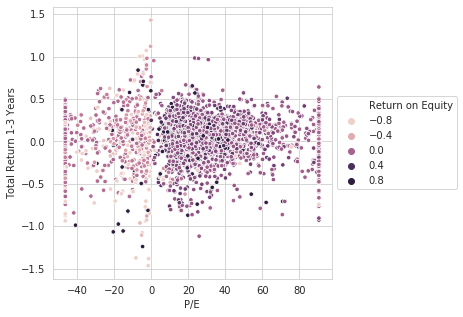

In [46]:
plot_scatter(df=df_sig_rets, x=PE, y=TOTAL_RETURN_1_3Y, hue=ROE);

Note that these scatter-plots only use a sample of 5000 randomly selected points, because there is actually more than 1.5 million data-points, which would make the plotting very slow (or even crash the program), and even if it worked, it would make the plot very messy to look at. Because of the random sampling, the plots may change slightly if you run the function again, but the plots should generally be representative of the entire data-set.

Now let us try and restrict the plot to only show the data-points where the stock-screener's criteria were met. This is still a blob of points, but perhaps not quite as random as before. The points are also shifted upwards because they tend to have more positive stock-returns.

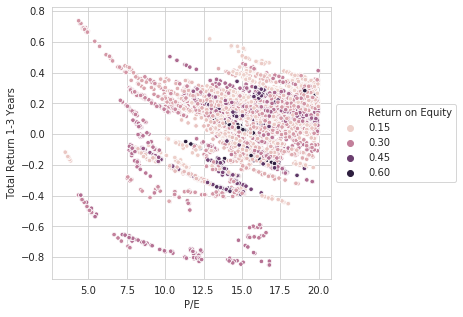

In [47]:
plot_scatter(df=df_match, x=PE, y=TOTAL_RETURN_1_3Y, hue=ROE);

If we plot it for only some of the tickers, then we can see a characteristic downward-trending slope, which is the topic of [this research](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z). It turns out there is a mathematical reason why we are observing this downwards slope in the data, as explained [here](https://www.youtube.com/watch?v=OFCHKYgGJRA). The slope always has the same shape, it is just shifted up or down depending on the company's future sales and earnings growth, and its future stock-valuation ratio.

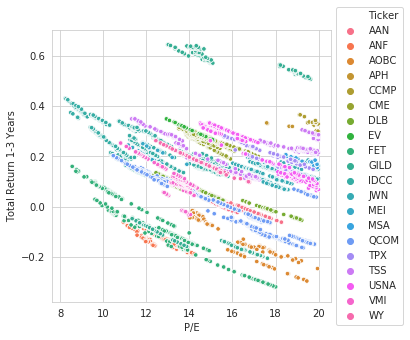

In [48]:
# Get all tickers that match the screener-criteria at some point.
all_tickers = df_match[[PE, TOTAL_RETURN_1_3Y]].dropna().reset_index()[TICKER].unique()

# Randomly select some of those tickers.
tickers = np.random.choice(all_tickers, size=20, replace=False)

# Make the scatter-plot for only those tickers.
plot_scatter(df=df_match.loc[tickers].reset_index(),
             x=PE, y=TOTAL_RETURN_1_3Y, hue=TICKER);

## Optimization

We can also automatically optimize the parameters of the screener-criteria by using a heuristic optimizer such as [Differential Evolution](https://en.wikipedia.org/wiki/Differential_evolution) as implemented in the [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) library. Because this optimizer does not require the mathematical gradient of the problem, it can often optimize very hard problems that cannot be made into simple mathematical formulas.

We will use a simplified screener in this example. First we define the boundaries for the screener's parameters:

In [0]:
bounds = \
[
    (1e6, 1e12),  # mcap_min
    (0.0, 1.0),   # debt_ratio_max
    (0.0, 30.0),  # pe_min
    (0.0, 50.0),  # pe_max
    (0.0, 1.0),   # roa_min
    (0.0, 1.0),   # roe_min
    (-0.2, 0.5),  # sales_growth_min
]

Then we define a function for running the stock-screener, which returns the rows from `df_sig_rets` that match the screener-criteria with the given parameters. This is a simpler version of the stock-screeners we made above.

In [0]:
def screener(x):
    """
    Run the stock-screener with the given parameters x
    and return only the rows that satisfy the screen-criteria.
    
    :param x: Array with parameters for the screener.
    :return: Pandas DataFrame.
    """

    # Unpack the screener-parameters.
    mcap_min, debt_ratio_max, pe_min, pe_max, roa_min, \
        roe_min, sales_growth_min = x
    
    # Start the screener with a market-cap condition.
    mask = (df_sig_rets[MARKET_CAP] > mcap_min)

    # Screener criteria where NaN signals are ignored.
    mask &= ((df_sig_rets[DEBT_RATIO] < debt_ratio_max) | (df_sig_rets[DEBT_RATIO].isnull()))
    mask &= ((df_sig_rets[ROA] > roa_min) | (df_sig_rets[ROA].isnull()))
    mask &= ((df_sig_rets[ROE] > roe_min) | (df_sig_rets[ROE].isnull()))
    mask &= (((df_sig_rets[PE] > pe_min) & (df_sig_rets[PE] < pe_max)) | (df_sig_rets[PE].isnull()))
    mask &= ((df_sig_rets[SALES_GROWTH] > sales_growth_min) | (df_sig_rets[SALES_GROWTH].isnull()))

    # Select the rows that satisfy the screener criteria.
    df_match = df_sig_rets.loc[mask]
    
    return df_match

Then we define the objective function (aka. cost or fitness function) that must be *minimized*. This basically just wraps the screener-function above and measures the median returns for stocks that match the screener-criteria with the given parameters.

The objective function also penalizes screener-parameters that result in too few matching stocks or too few data-points, so as to avoid over-fitting the screener-parameters to just a few stocks that happened to perform really well during this period.

In [0]:
def objective(x):
    """
    Function whose return-value must be minimized by changing
    the screener parameters x.
    
    :param x: Array with parameters for the screener.
    :return: Float to be minimized.
    """

    # Run the stock-screener and get the matching rows, which
    # contain a Ticker and Date as well as the signals and
    # future stock-returns.
    df_match = screener(x)

    # Did the stock-screener find any matching rows?
    if len(df_match)>0:
        # Get the stock-returns for the matching rows.
        # Drop NaN-rows because we count the rows further below.
        df_returns = df_match[TOTAL_RETURN_1_3Y].dropna()

        # The optimization objective is the MEDIAN stock-return.
        # We use this instead of the mean to avoid outliers.
        # It is negated because the optimizer performs
        # minimization, but we are actually interested in
        # maximizing the median stock-return.
        objective = -df_returns.median()
    
        # Now we will penalize the objective to try and find
        # stock-screener parameters that result in certain
        # characteristics for the matching stocks.
        
        # Initialize the penalty. This number will be lowered
        # towards zero in the tests below, and finally multiplied
        # with the objective value.
        penalty = 1.0

        # Gradually penalize when there are fewer data-points.
        limit = 50000
        if len(df_returns) < limit:
            penalty *= len(df_returns) / limit

        # Gradually penalize when there are fewer unique stocks.
        num_tickers = len(df_returns.reset_index()[TICKER].unique())
        limit = 100
        if num_tickers < limit:
            penalty *= num_tickers / limit

        # Gradually penalize when there are fewer stocks per day
        # on average.
        num_per_day = df_returns.reset_index()[[DATE, TICKER]].groupby(DATE).count()
        mean = num_per_day[TICKER].mean()
        limit = 50
        if mean < limit:
            penalty *= mean / limit

        # Gradually penalize when the P/E signal is missing / NaN.
        penalty *= len(df_match[PE].dropna()) / len(df_match)

        # Apply the penalty to the objective function.
        objective *= penalty
    else:
        # The stock-screener did not find any matching rows,
        # so use a very high value. A small random value is
        # added to avoid premature stagnation of the optimizer,
        # in case all trials in its populations have the exact
        # same objective value.
        objective = 1000.0 + np.random.rand()
        
    return objective

We will also need a small helper-function for printing the best-found screener-parameters:

In [0]:
def print_parameters(x):
    """
    Print the parameters for the screener-criteria.
    
    :param x: Array with parameters for the screener.
    """
    
    # Unpack the parameters.
    mcap_min, debt_ratio_max, pe_min, pe_max, roa_min, \
        roe_min, sales_growth_min = x

    # Print the parameters.
    print('Market-Cap Min:   {:.0}'.format(mcap_min))
    print('Debt Ratio Max:   {:.2f}'.format(debt_ratio_max))
    print('P/E Min:          {:.1f}'.format(pe_min))
    print('P/E Max:          {:.1f}'.format(pe_max))
    print('ROA Min:          {:.2f}'.format(roa_min))
    print('ROE Min:          {:.2f}'.format(roe_min))
    print('Sales Growth Min: {:.2f}'.format(sales_growth_min))

We can then run the optimization. This may take several minutes on a quad-core CPU.

In [53]:
%%time
# Only do a short run if this is run using pytest.
# This is to save time during automated testing.
maxiter = 2 if running_pytest else 30

# Run the optimization.
# Note the increased population-size which seemed to
# perform better than the default choice of only 15.
result = differential_evolution(func=objective, bounds=bounds,
                                popsize=30, disp=True,
                                maxiter=maxiter)

# Get the best-found screener parameters.
best_parameters = result.x

differential_evolution step 1: f(x)= -0.0421815
differential_evolution step 2: f(x)= -0.0421815
differential_evolution step 3: f(x)= -0.0421815
differential_evolution step 4: f(x)= -0.0437265
differential_evolution step 5: f(x)= -0.0437265
differential_evolution step 6: f(x)= -0.0503599
differential_evolution step 7: f(x)= -0.0846018
differential_evolution step 8: f(x)= -0.0846018
differential_evolution step 9: f(x)= -0.0876395
differential_evolution step 10: f(x)= -0.0885518
differential_evolution step 11: f(x)= -0.0885518
differential_evolution step 12: f(x)= -0.089657
differential_evolution step 13: f(x)= -0.09008
differential_evolution step 14: f(x)= -0.09008
differential_evolution step 15: f(x)= -0.0908858
differential_evolution step 16: f(x)= -0.0908858
differential_evolution step 17: f(x)= -0.0913988
differential_evolution step 18: f(x)= -0.0913988
differential_evolution step 19: f(x)= -0.0913988
differential_evolution step 20: f(x)= -0.091727
differential_evolution step 21: f(x

These are the optimized screener-parameters that gave the best investment performance:

In [54]:
print_parameters(x=best_parameters)

Market-Cap Min:   4e+10
Debt Ratio Max:   0.88
P/E Min:          11.6
P/E Max:          49.7
ROA Min:          0.03
ROE Min:          0.06
Sales Growth Min: -0.16


We can then try and run the stock-screener with the optimized parameters, and make a scatter-plot of the matching P/E ratios versus the average 1-3 year stock-returns:

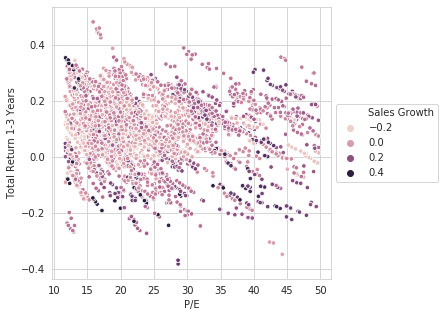

In [55]:
# Run the screener with the optimized parameters,
# and get the rows that satisfy the screener-criteria.
df_match = screener(best_parameters)

# Scatter-plot of the P/E versus stock-returns.
plot_scatter(df=df_match, x=PE, y=TOTAL_RETURN_1_3Y,
             hue=SALES_GROWTH);

We can also print the basic statistics for the average 1-3 year stock-returns from the screener with the optimized parameters. Note that these are actually worse than for the stock-screener and parameters we had made further above. The reason is probably that the optimized screener-parameters also try to ensure that the screener finds a diverse set of stocks, and that the P/E signals are actually present; while the stock-screener further above would also select stocks where the P/E signal was NaN (Not-a-Number).

In [56]:
df_match[TOTAL_RETURN_1_3Y].describe()

count    83561.000000
mean         0.108338
std          0.205389
min         -4.985282
25%          0.051077
50%          0.122696
75%          0.190617
max          0.710447
Name: Total Return 1-3 Years, dtype: float64

We can also show how many stocks the screener found for every single day. We had programmed the `objective()` function so it would penalize the screener-parameters, if they resulted in there being an average of fewer than 50 stocks that matched the screener every day.

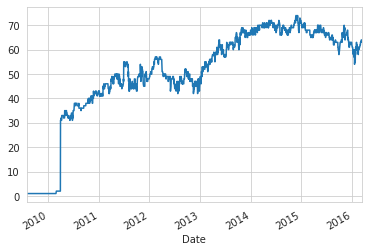

In [57]:
df_match[TOTAL_RETURN_1_3Y].dropna().groupby(DATE).count().plot(grid=True);

For every day, we can show the average 1-3 year return for all the stocks matching the screener with the optimized parameters. We can see that the screener seems to work better in some periods than others.

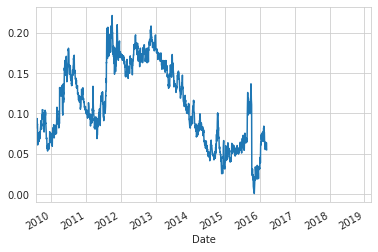

In [58]:
df_match[TOTAL_RETURN_1_3Y].groupby(DATE).mean().plot();

## Research Ideas

The screener optimization shown above can be extended in many different ways. Here are a few ideas to get you started:

- Split the data-set into training- and test-sets as shown in the other SimFin tutorials on Machine Learning. Does the screener work just as well on stock-data that it has not seen during the training?

- Create an *ensemble* of stock-screeners by making different screeners that are specialized for different things, e.g. one screener could be specialied for high-growth companies, and another screener could be specialized for under-valued companies. You can also run the optimization several times for each screener, and then average all of the results when building your investment portfolio.

- Use multi-objective optimization to find optimal trade-offs e.g. between average returns and probability of loss. You can modify this [implementation](https://github.com/Hvass-Labs/FinanceOps/blob/master/04_Multi-Objective_Portfolio_Optimization.ipynb).

- Use Genetic Programming to optimize both the screener-parameters and the entire screener-formula, to find which signals should be used, how they should be used, and what the parameters should be.

Please share your results with the rest of the community, that is what SimFin is made for!

## License (MIT)

This is published under the
[MIT License](https://github.com/simfin/simfin-tutorials/blob/master/LICENSE.txt)
which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/simfin/simfin-tutorials).
